In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from collections import Counter
import os

In [34]:
def get_entity_and_relation_dicts(path: str):
    entities = Counter()
    relations = Counter()
    with open(path, "r") as f:
        for line in f:
            head, rel, tail = line[:-1].split("\t")
            entities.update([head, tail])
            relations.update([rel])
    relation_idx = {}
    entity_idx = {}
    for idx, (entity, _) in enumerate(entities.most_common()):
        entity_idx[entity] = idx
    for idx, (rel, _) in enumerate(relations.most_common()):
        relation_idx[rel] = idx
    return entity_idx, relation_idx

In [35]:
class WordNet18RR(torch.utils.data.Dataset):
    def __init__(self, data_path: str, entity_idx, relation_idx):
        self.relation_idx = relation_idx
        self.entity_idx = entity_idx
        with open(data_path, "r") as data_file:
            self.data = [triplet[:-1].split("\t") for triplet in data_file]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        head, relation, tail = self.data[index]
        head_id = self._to_idx(head, self.entity_idx)
        relation_id = self._to_idx(relation, self.relation_idx)
        tail_id = self._to_idx(tail, self.entity_idx)
        return head_id, relation_id, tail_id

    @staticmethod
    def _to_idx(key: str, map):
        try:
            return map[key]
        except KeyError: # for unknown entity (if not in val set, but in train set for example)
            return len(map)


In [36]:
class MyTransE(nn.Module):

    def __init__(self, entities_num, relations_num, norm=1, embed_dim=100, margin=1.0):
        super(MyTransE, self).__init__()
        self.entities_num = entities_num
        self.relations_num = relations_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.norm = norm
        self.embed_dim = embed_dim
        self._init_enitity_emb()
        self._init_relation_emb()
        self.criterion = nn.MarginRankingLoss(margin=margin, reduction='none')

    def _init_enitity_emb(self):
        self.entities_emb = nn.Embedding(num_embeddings=self.entities_num + 1, embedding_dim=self.embed_dim,
                                    padding_idx=self.entities_num)
        uniform_range = 6 / np.sqrt(self.embed_dim)
        self.entities_emb.weight.data.uniform_(-uniform_range, uniform_range)

    def _init_relation_emb(self):
        self.relations_emb = nn.Embedding(num_embeddings=self.relations_num + 1, embedding_dim=self.embed_dim,
                                     padding_idx=self.relations_num)
        range = 6 / np.sqrt(self.embed_dim)
        self.relations_emb.weight.data.uniform_(-range, range)
        self.relations_emb.weight.data[:-1, :].div_(
            self.relations_emb.weight.data[:-1, :].norm(
            p=2, dim=1, keepdim=True)) # -1 for out of vocab embed

    def forward(self, solid_triplets, corrupted_triplets):
        self.entities_emb.weight.data[:-1, :].div_(
            self.entities_emb.weight.data[:-1, :].norm(
            p=2, dim=1, keepdim=True)) # -1 for out of vocab embed

        solid_distances = self.calc_distance(solid_triplets)
        corrupted_distances = self.calc_distance(corrupted_triplets)
        return self.loss(solid_distances, corrupted_distances)

    def predict(self, triplets):
        return self.calc_distance(triplets)

    def loss(self, positive_distances, negative_distances):
        return self.criterion(positive_distances, negative_distances, torch.tensor([-1], dtype=torch.long, device=self.device))

    def calc_distance(self, triplets):
        heads = triplets[:, 0]
        relations = triplets[:, 1]
        tails = triplets[:, 2]
        return (self.entities_emb(heads) + self.relations_emb(relations) - self.entities_emb(tails)).norm(p=self.norm,
                                                                                                          dim=1)


In [37]:
dataset_path = "datasets_knowledge_embedding/WN18RR/original/"
BATCH_SIZE = 32
NUM_EPOCH = 100
NORM = 2
MARGIN = 1.0
EMBED_DIM = 20
LR = 0.001



entity_idx, relation_idx = get_entity_and_relation_dicts(os.path.join(dataset_path, "train.txt"))

train_dataset = WordNet18RR(os.path.join(dataset_path, "train.txt"), entity_idx, relation_idx)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = WordNet18RR(os.path.join(dataset_path, "valid.txt"), entity_idx, relation_idx)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = WordNet18RR(os.path.join(dataset_path, "test.txt"), entity_idx, relation_idx)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyTransE(entities_num=len(entity_idx),
                 relations_num=len(relation_idx),
                 embed_dim=EMBED_DIM,
                 margin=MARGIN, norm=NORM)

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[1].set_ylabel('loss')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [39]:
def training_epoch(model, optimizer, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()

    for local_heads, local_relations, local_tails in tqdm(train_loader, desc=tqdm_desc):
        local_heads, local_relations, local_tails = (local_heads.to(device), local_relations.to(device),
                                                        local_tails.to(device))

        solid_triples = torch.stack((local_heads, local_relations, local_tails), dim=1)

        head_or_tail = torch.randint(high=2, size=local_heads.size(), device=device)
        random_entities = torch.randint(high=len(entity_idx), size=local_heads.size(), device=device)
        broken_heads = torch.where(head_or_tail == 1, random_entities, local_heads)
        broken_tails = torch.where(head_or_tail == 0, random_entities, local_tails)
        corrupted_triples = torch.stack((broken_heads, local_relations, broken_tails), dim=1)

        optimizer.zero_grad()

        loss = model(solid_triples, corrupted_triples)
        loss.mean().backward()

        train_loss += loss.mean().item()

        optimizer.step()
    
    return train_loss / len(train_loader)


@torch.no_grad()
def validation_epoch(model, test_loader, tqdm_desc):
    test_loss = 0.0
    
    model.eval()
    for local_heads, local_relations, local_tails in tqdm(test_loader, desc=tqdm_desc):
        local_heads, local_relations, local_tails = (local_heads.to(device), local_relations.to(device),
                                                        local_tails.to(device))

        solid_triples = torch.stack((local_heads, local_relations, local_tails), dim=1)

        head_or_tail = torch.randint(high=2, size=local_heads.size(), device=device)
        random_entities = torch.randint(high=len(entity_idx), size=local_heads.size(), device=device)
        broken_heads = torch.where(head_or_tail == 1, random_entities, local_heads)
        broken_tails = torch.where(head_or_tail == 0, random_entities, local_tails)
        corrupted_triples = torch.stack((broken_heads, local_relations, broken_tails), dim=1)

        loss = model(solid_triples, corrupted_triples)

        test_loss += loss.mean().item()
    
    return test_loss / len(test_loader)

    
def train(model, optimizer, train_loader, test_loader, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss = validation_epoch(
            model, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        train_losses += [train_loss]
        test_losses += [test_loss]
        plot_losses(train_losses, test_losses)

    return train_losses, test_losses

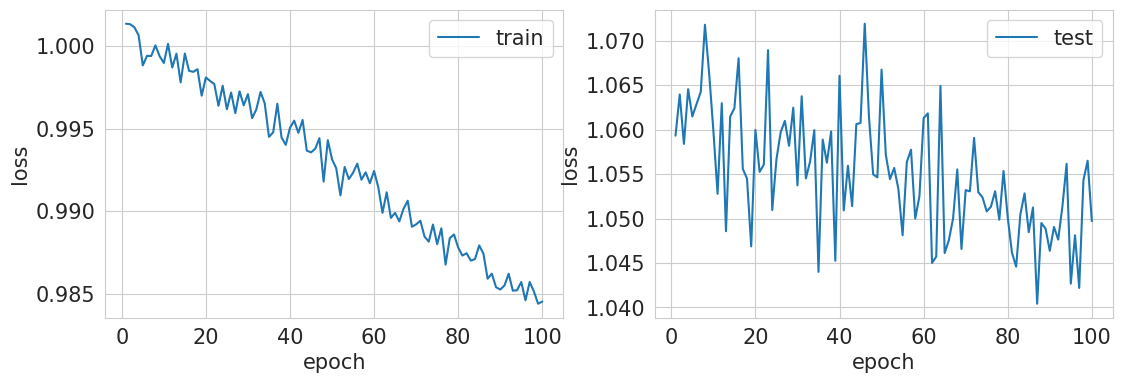

([1.0013335837145982,
  1.0013041240859752,
  1.0011233219831588,
  1.0006359249858532,
  0.9988143213241524,
  0.9993918975355349,
  0.9993817890138422,
  1.000025585238865,
  0.9993737449783039,
  0.9989601114302237,
  1.0001164400234939,
  0.9986854721143479,
  0.999523024240134,
  0.9977882547288935,
  0.9995315572358091,
  0.9984913343617208,
  0.9984226632223643,
  0.9985838058948868,
  0.9969857046291419,
  0.9980870081865357,
  0.9978743763468946,
  0.9976910687186916,
  0.9963708246070494,
  0.997585286045215,
  0.9961601831540521,
  0.9971755916745503,
  0.9959291355216336,
  0.9972474579654728,
  0.9964001172592118,
  0.9970774969900015,
  0.9956253812913958,
  0.9961555059244287,
  0.9972084003199351,
  0.9965180281162613,
  0.9944937311733305,
  0.9947644480248102,
  0.9964953282341504,
  0.9944513388960873,
  0.9940122614121208,
  0.9950389015648237,
  0.995474982630618,
  0.9947380740895548,
  0.9955164586786145,
  0.9936659178623137,
  0.993556117409718,
  0.99377375454

In [40]:
train(
    model, optimizer, train_dataloader, test_dataloader, NUM_EPOCH
)